In [ ]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torchvision
from preprocessing import get_piano_roll_from_path
from torchsummary import summary
import mido
import os
import random

### Preprocessing

In [ ]:

directory = "../dataset"
filenames = []
DATASET_SIZE = 100
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
        # if len(train_data) < DATASET_SIZE:
        #     train_data.append(get_piano_roll_from_path(fs=SELECTED_FS))
        # else:
        #     break

In [ ]:
random.shuffle(filenames)
filenames_size = len(filenames)
train_filenames = filenames[:(filenames_size // 2)]
test_filenames = filenames[(filenames_size // 2):]

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

def generate_roll(batch):
    results = []
    for mid_filename in batch:
        results.append(get_piano_roll_from_path(
            midi_file_name=mid_filename,
            fs=SELECTED_FS)
        )
    return results


train_data = DataLoader(train_filenames, batch_size=BATCH_SIZE, collate_fn=generate_roll)

In [ ]:
# Helper function to calculate output size after convolution
def calc_outsize(input_size=32, kernel_size=3, padding=0, stride=1):
    out_size = (input_size - kernel_size + 2 * padding) / stride + 1
    return out_size

### Model

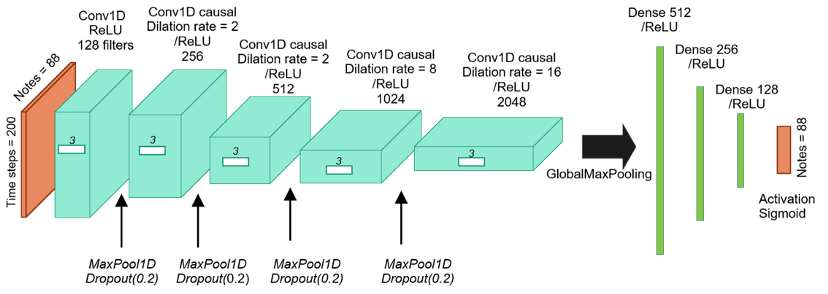

The following architecture was adopted from TensorFlow implementation of Phillip Petit, Gatien Vassor, Emna Bairam and Wladimir Raymond: https://towardsdatascience.com/pyzzicato-piano-instrumental-music-generation-using-deep-neural-networks-ed9e89320bf6

Speaking short, this is a pseudo-WaveNet architecture, having five convolution blocks and one linear block. We did not want to use Tensorflow, therefore we implemented this architecture using PyTorch.

In [ ]:
n_notes = 88
len_feats = 1000  #temp value


class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.__padding = (kernel_size - 1) * dilation

    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class GlobalMaxPooling1D(nn.Module):

    def __init__(self, data_format='channels_first'):
        super(GlobalMaxPooling1D, self).__init__()
        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.max(input, axis=self.step_axis).values


class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(n_notes, 128, 3)
        self.conv2 = CausalConv1d(128, 256, 3, dilation=2)
        self.conv3 = CausalConv1d(256, 512, 3, dilation=4)
        self.conv4 = CausalConv1d(512, 1024, 3, dilation=8)
        self.conv5 = CausalConv1d(1024, 2048, 3, dilation=16)

        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)
        self.global_max_pool = GlobalMaxPooling1D()

        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, n_notes)

    def forward(self, x):
        x = self.pool(self.dropout(self.conv1(x)))
        x = self.pool(self.dropout(self.conv2(x)))
        x = self.pool(self.dropout(self.conv3(x)))
        x = self.pool(self.dropout(self.conv4(x)))
        x = self.pool(self.dropout(self.conv5(x)))

        x = self.global_max_pool(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [ ]:
model = Model()
summary(model, (n_notes, len_feats))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 998]          33,920
           Dropout-2             [-1, 128, 998]               0
         MaxPool1d-3             [-1, 128, 499]               0
      CausalConv1d-4             [-1, 256, 499]          98,560
           Dropout-5             [-1, 256, 499]               0
         MaxPool1d-6             [-1, 256, 249]               0
      CausalConv1d-7             [-1, 512, 249]         393,728
           Dropout-8             [-1, 512, 249]               0
         MaxPool1d-9             [-1, 512, 124]               0
     CausalConv1d-10            [-1, 1024, 124]       1,573,888
          Dropout-11            [-1, 1024, 124]               0
        MaxPool1d-12             [-1, 1024, 62]               0
     CausalConv1d-13             [-1, 2048, 62]       6,293,504
          Dropout-14             [-1, 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Training model

In [ ]:
# loop over our epochs

for e in range(0, EPOCHS):
	model.train()
	totalTrainLoss = 0
	totalValLoss = 0
	trainCorrect = 0
	valCorrect = 0
	for x in trainDataLoader:
		x = x.to(device)
		pred = model(x)
		loss = lossFn(pred, x[pred.shape[0] + 1])
		opt.zero_grad()
		loss.backward()
		opt.step()
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

### Track prediction

In [ ]:
len_feats = 200
SELECTED_FS = 20


def predict_track(track_length, sigmoid_threshold, model, data, chosen_seed):
    seeds = [data[i][0] for i in range(len(data))]
    seed_names = [data[i][3] for i in range(len(data))]
    seed = seeds[seed_names.index(chosen_seed)]
    sequence = seed

    for note_index in (range(track_length)):
        pred = model.predict(np.expand_dims(sequence[note_index:, :], 0))
        pred = np.where(pred > sigmoid_threshold, 1, 0)
        sequence = np.vstack((sequence, pred))

    piano_roll = np.concatenate((np.zeros(shape=(SELECTED_FS, track_length)), np.asarray(sequence)[len_feats:, ].T),
                                axis=0)
    piano_roll = np.concatenate((piano_roll, np.zeros(shape=(SELECTED_FS, track_length))), axis=0)

    return piano_roll